<a href="https://colab.research.google.com/github/nadireus/Clarusway/blob/main/CNN_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Image Classification with CNN


Welcome to second assignment of Deep learning lesson. Follow the instructions and complete the assignment.

------------

## Task

**Build an image classifier with Convolutional Neural Networks for the Fashion MNIST dataset. This data set includes 10 labels of different clothing types with 28 by 28 *grayscale* images. There is a training set of 60,000 images and 10,000 test images.**

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot
    
 

In [2]:
import os

In [ ]:
import tensorflow as tf
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
with strategy.scope():
 model = create_model()#Build your model


##Import Libraries

In [ ]:
!pip install keras.utils

In [7]:
import pandas as pd
import seaborn as sns
import tensorflow as tf                       
import numpy as np                           

from tensorflow.keras.layers import Dense, Activation, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix
from keras.utils.vis_utils import model_to_dot
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt    
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from tensorflow.keras.layers import BatchNormalization

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



In [8]:
np.set_printoptions(suppress=True)

## The Data

**Download the fashion mnist dataset using Keras.**

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [10]:
print("There are ", len(x_train), "images in the training dataset")     
print("There are ", len(x_test), "images in the test dataset")   

There are  60000 images in the training dataset
There are  10000 images in the test dataset


In [11]:
# Checking the shape of one image
x_train[5].shape

(28, 28)

In [ ]:
x_train[5]

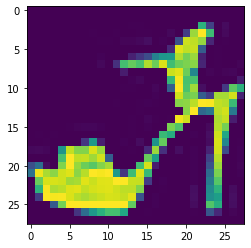

In [13]:
plt.imshow(x_train[9])

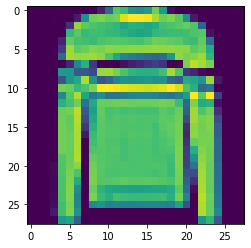

In [14]:
plt.imshow(x_train[5])
# plt.matshow(X_train[5])

In [16]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [15]:
y_train[5]

2

In [17]:
x_train.shape

(60000, 28, 28)

In [18]:
y_train.shape

(60000,)

In [19]:
# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))



# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))

Train labels:  {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}

Test labels:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [20]:
y_traindf=pd.DataFrame(y_train)

In [21]:
y_traindf

,0
0,9
1,0
2,0
3,3
4,0
...,...
59995,5
59996,1
59997,3
59998,0


In [22]:
#Rename  Column
y_traindf.rename(columns = {0:'labels'}, inplace = True)

In [23]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}


In [24]:
def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["labels"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(y_traindf)

Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



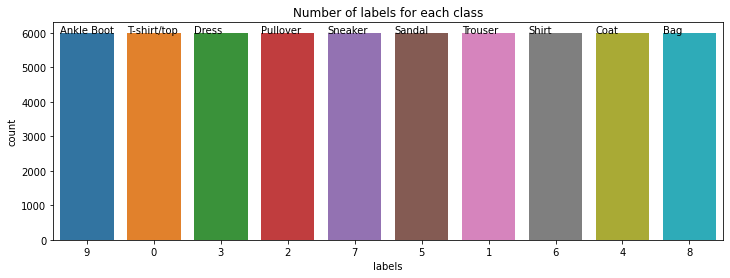

In [25]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.labels, order = data["labels"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["labels"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(y_traindf)

## Visualizing the Data

**Using matplotlib show an any image from the data set.**

In [26]:
classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [27]:
int(np.random.randint(low=0, high=50000, size=1))

24594

###Train set images

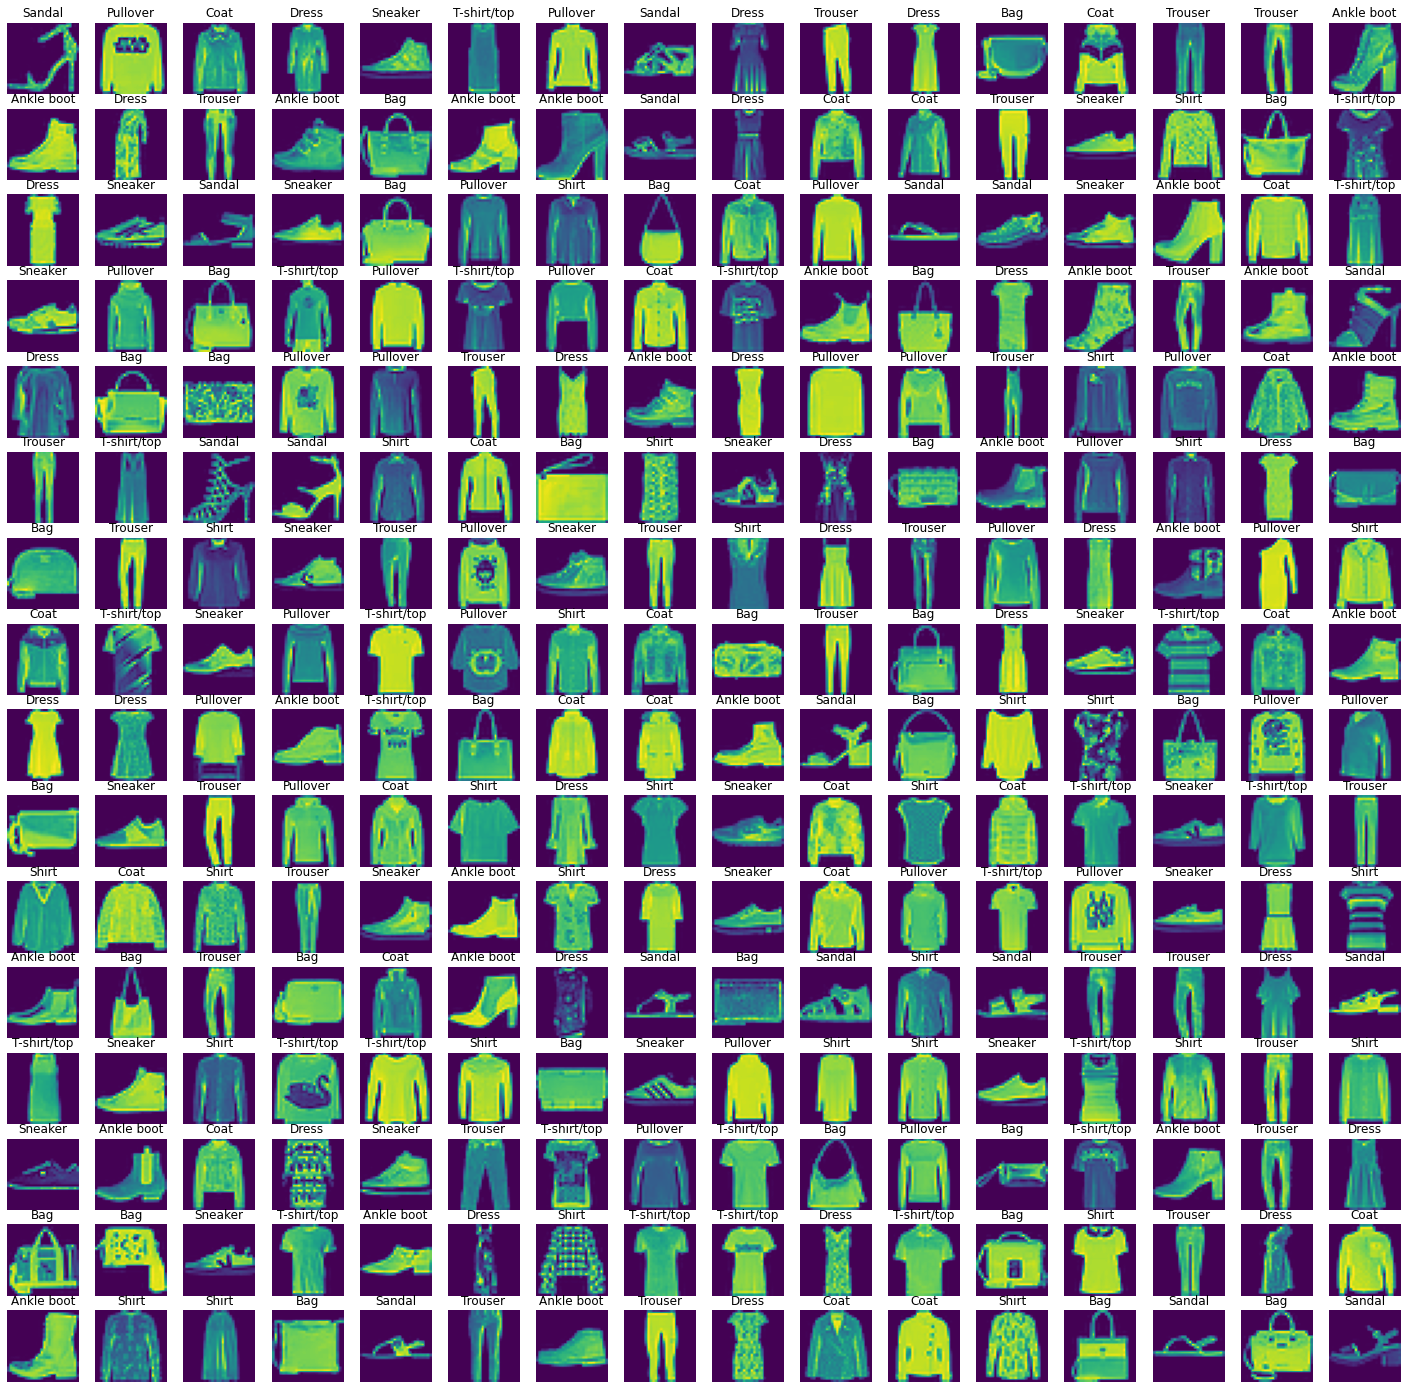

In [29]:
plt.figure(figsize=(25, 25))
for i in range(256):
    rand_index = int(np.random.randint(low=0, high=50000, size=1))
    plt.subplot(16, 16, i+1, label=classes[int(y_train[rand_index])])
    plt.axis('off')
    plt.title(classes[int(y_train[rand_index])])
    plt.imshow(x_train[rand_index])    

##Test set images

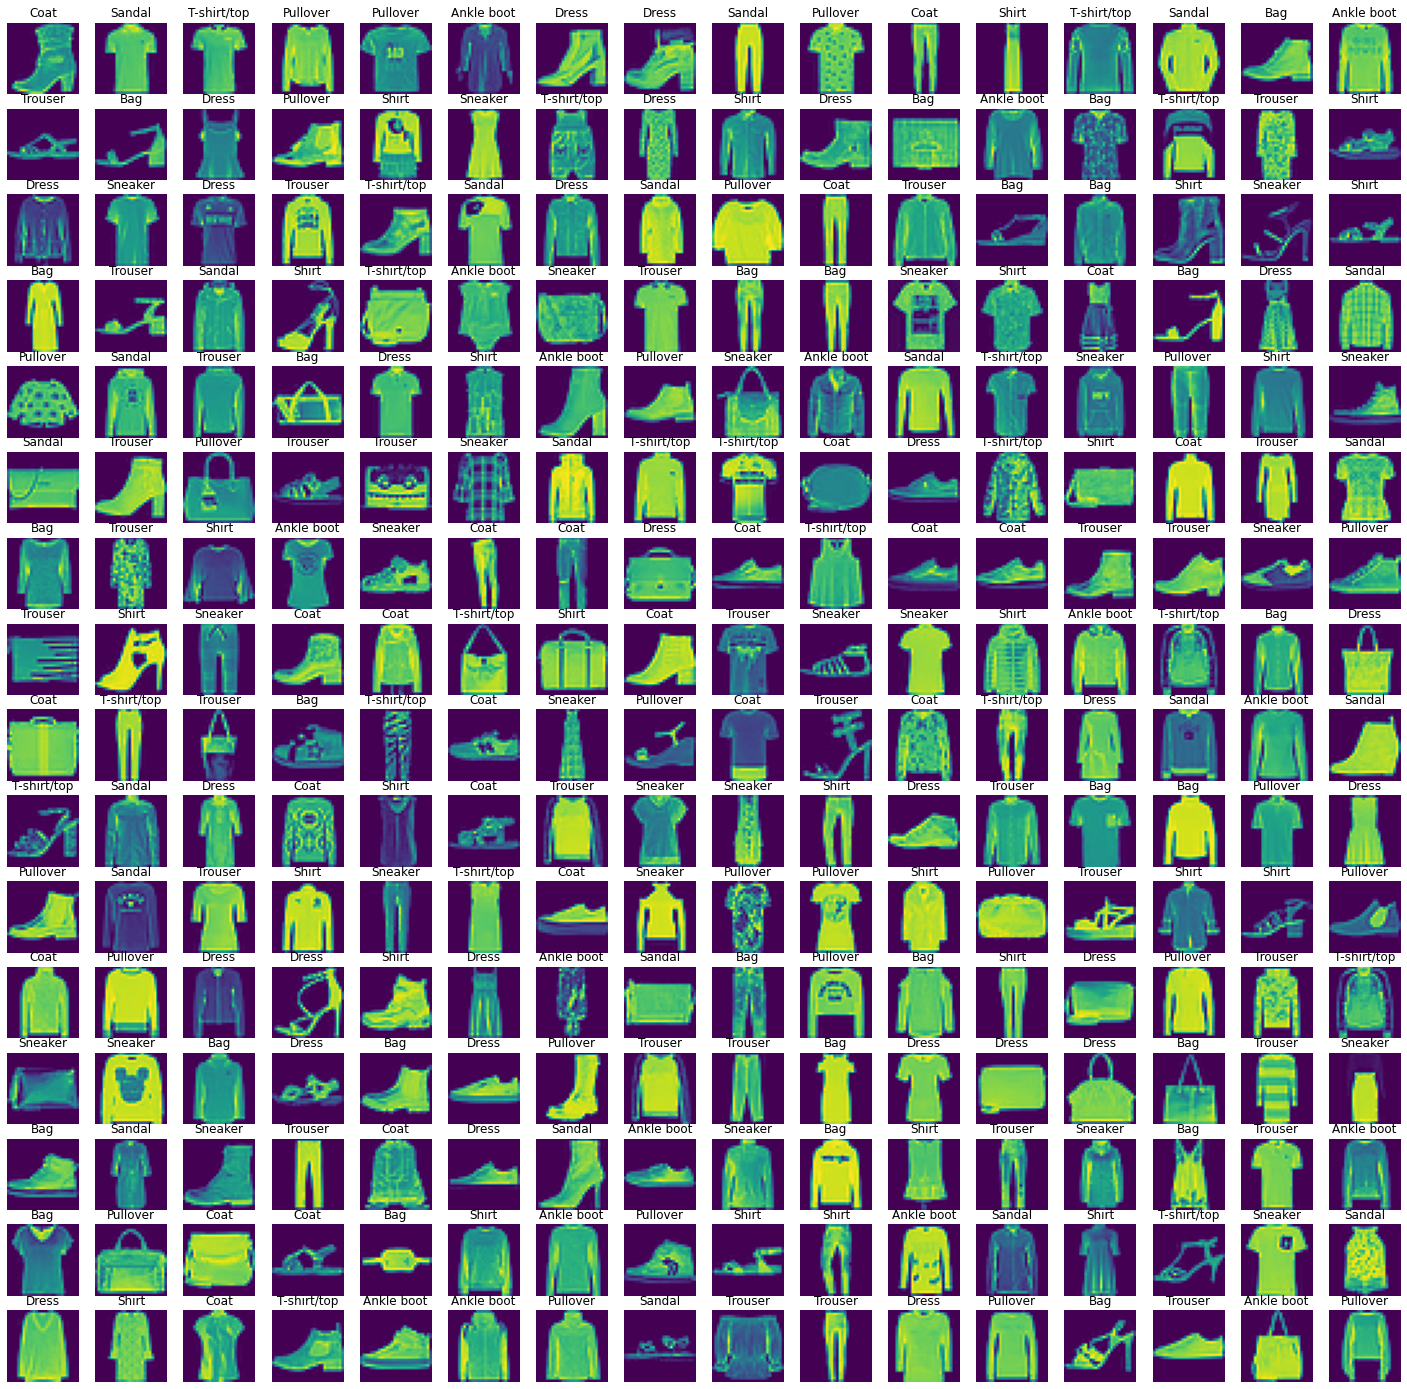

In [30]:
plt.figure(figsize=(25, 25))
for i in range(256):
    rand_index = int(np.random.randint(low=0, high=10000, size=1))
    plt.subplot(16, 16, i+1, label=classes[int(y_test[rand_index])])
    plt.axis('off')
    plt.title(classes[int(y_train[rand_index])])
    plt.imshow(x_test[rand_index])  

In [31]:
x_train[5].min()

0

In [32]:
x_train[5].max()

255

#Reshape 

In [33]:
# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

##Prepare Pixel Data
We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [34]:
# convert from integers to floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# normalize to range 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

In [35]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

#### Dropout layer extra info

[External link to the keras documentation about dropout layers. An important read!](https://keras.io/api/layers/regularization_layers/dropout/)

## Setting network parameters

The batch_size argument indicates the number of data that we will use for each update of the model parameters.

Dropout is the dropout rate (Overfitting and Regularization).

### Designing the model architecture

The main data structure in Keras is the Sequential class, which allows the creation of a basic neural network.

The Sequential class of the Keras library is a wrapper for the sequential neural network model that Keras offers and can be created in the following way:

from keras.models import Sequential

model = Sequential()

The model in Keras is considered as a sequence of layers and each of them gradually “distills” the input data to obtain the desired output.

In Keras, we can add the required types of layers through the add() method.

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu', padding='same'))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu', padding='same'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu', padding='same'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Create the model

2D Convolutional Layer, filters=28 and kernel_size=(3,3)

Pooling Layer where pool_size = (2,2) strides=(1,1)

Flatten Layer

Dense Layer (128 Neurons, but feel free to play around with this value), RELU activation

Final Dense Layer of 10 Neurons with a softmax activation

Then compile the model with these parameters: loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']

##Model

In [40]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 28, 28, 64)       

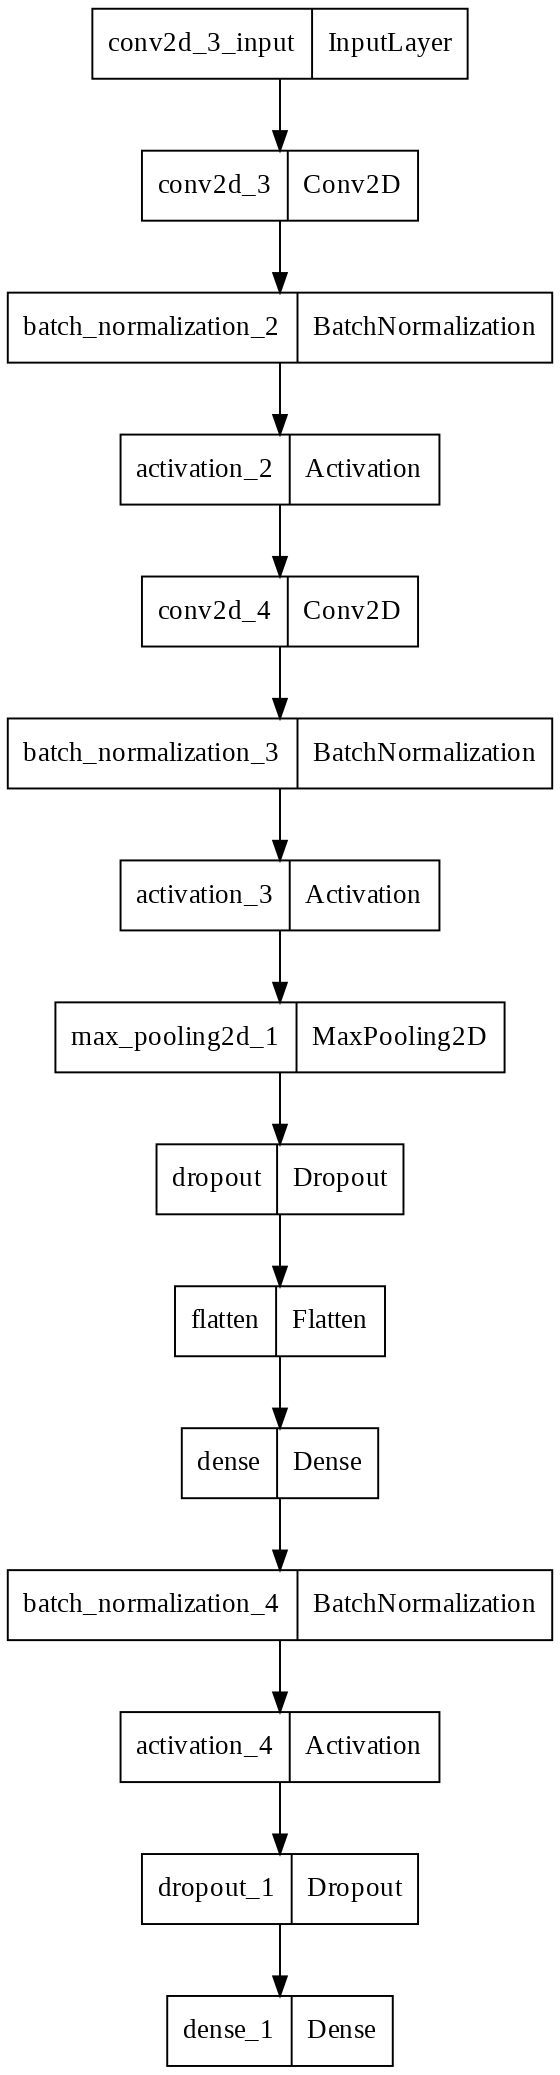

In [43]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png',dpi=140)

In [44]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [45]:
model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test,y_test),callbacks=[early_stop])

Epoch 1/15
1875/1875 [==============================] - 96s 50ms/step - loss: 0.3816 - accuracy: 0.8640 - val_loss: 0.2791 - val_accuracy: 0.8972
Epoch 2/15
1875/1875 [==============================] - 102s 54ms/step - loss: 0.2542 - accuracy: 0.9065 - val_loss: 0.2533 - val_accuracy: 0.9087
Epoch 3/15
1875/1875 [==============================] - 100s 53ms/step - loss: 0.2109 - accuracy: 0.9232 - val_loss: 0.2335 - val_accuracy: 0.9152
Epoch 4/15
1875/1875 [==============================] - 98s 52ms/step - loss: 0.1788 - accuracy: 0.9336 - val_loss: 0.2322 - val_accuracy: 0.9187
Epoch 5/15
1875/1875 [==============================] - 97s 52ms/step - loss: 0.1493 - accuracy: 0.9442 - val_loss: 0.2397 - val_accuracy: 0.9174
Epoch 6/15
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1287 - accuracy: 0.9517 - val_loss: 0.2356 - val_accuracy: 0.9207
Epoch 7/15
1875/1875 [==============================] - 100s 53ms/step - loss: 0.1099 - accuracy: 0.9591 - val_loss: 0.233

In [46]:
model.metrics_names

['loss', 'accuracy']

In [47]:
model.history.history

{'accuracy': [0.8640166521072388,
  0.9065166711807251,
  0.9232000112533569,
  0.9336166381835938,
  0.9441999793052673,
  0.9517166614532471,
  0.9591166377067566,
  0.9650833606719971,
  0.9696000218391418,
  0.972683310508728,
  0.977316677570343,
  0.9781833291053772,
  0.9814666509628296,
  0.9838333129882812],
 'loss': [0.38155099749565125,
  0.2541804611682892,
  0.21086882054805756,
  0.17882031202316284,
  0.14931929111480713,
  0.12867222726345062,
  0.10987890511751175,
  0.09481263160705566,
  0.08413651585578918,
  0.07283204793930054,
  0.061844147741794586,
  0.05932971090078354,
  0.052447959780693054,
  0.04768737778067589],
 'val_accuracy': [0.8971999883651733,
  0.9086999893188477,
  0.9151999950408936,
  0.9186999797821045,
  0.9174000024795532,
  0.9207000136375427,
  0.9333000183105469,
  0.932699978351593,
  0.9319999814033508,
  0.9298999905586243,
  0.9275000095367432,
  0.9351000189781189,
  0.9358999729156494,
  0.9355999827384949],
 'val_loss': [0.279105633

In [48]:
summary = pd.DataFrame(model.history.history)
summary.head(11)

,loss,accuracy,val_loss,val_accuracy
0,0.381551,0.864017,0.279106,0.8972
1,0.254180,0.906517,0.253337,0.9087
2,0.210869,0.923200,0.233465,0.9152
3,0.178820,0.933617,0.232221,0.9187
4,0.149319,0.944200,0.239704,0.9174
5,0.128672,0.951717,0.235636,0.9207
6,0.109879,0.959117,0.233572,0.9333
7,0.094813,0.965083,0.248696,0.9327
8,0.084137,0.969600,0.210664,0.9320
9,0.072832,0.972683,0.230937,0.9299


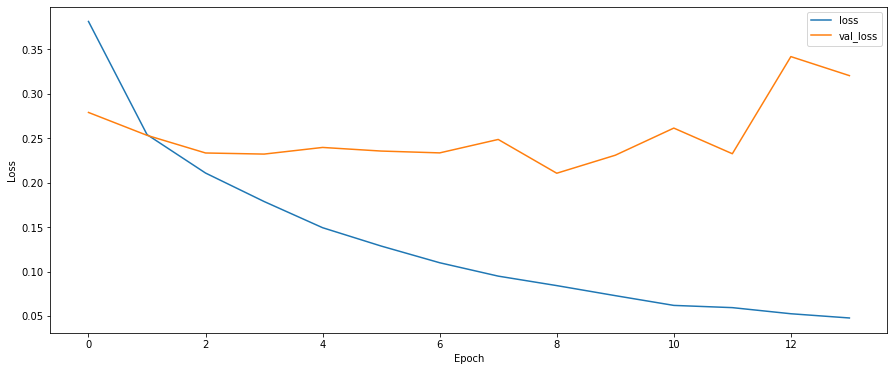

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

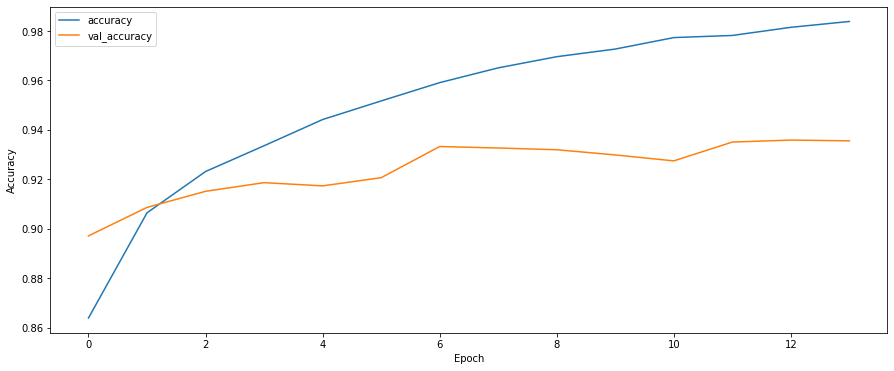

In [50]:
plt.figure(figsize=(15, 6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [51]:
print(model.evaluate(x_test, y_test, verbose=1))

313/313 [==============================] - 5s 17ms/step - loss: 0.3206 - accuracy: 0.9356
[0.32055753469467163, 0.9355999827384949]


In [52]:
from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix

In [53]:
predictions =np.argmax(model.predict(x_test), axis=-1)

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
print(confusion_matrix(y_test, predictions))

In [56]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.32055753469467163
Test accuracy: 0.9355999827384949


In [ ]:
my_image = x_test[44]

In [ ]:
plt.imshow(my_image)

In [ ]:
image_prediction = model.predict(my_image.reshape(1,28,28,1))
image_prediction

In [ ]:
result=np.argmax(image_prediction, axis=1)
result

In [ ]:
classes[int(result)]

In [58]:
model.save("cnn-1.h5")

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=15)

In [64]:
model= Sequential()
model.add(Conv2D(filters=28,kernel_size=(3,3),activation='relu',input_shape=(28,28,1), padding='same'))
        
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))
    
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))
        
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [65]:
model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test,y_test), callbacks=[early_stop])

Epoch 1/100
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4159 - accuracy: 0.8484 - val_loss: 0.2825 - val_accuracy: 0.8977
Epoch 2/100
1875/1875 [==============================] - 41s 22ms/step - loss: 0.2740 - accuracy: 0.8986 - val_loss: 0.2578 - val_accuracy: 0.9027
Epoch 3/100
1875/1875 [==============================] - 41s 22ms/step - loss: 0.2355 - accuracy: 0.9129 - val_loss: 0.2426 - val_accuracy: 0.9123
Epoch 4/100
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2122 - accuracy: 0.9206 - val_loss: 0.2112 - val_accuracy: 0.9234
Epoch 5/100
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1969 - accuracy: 0.9262 - val_loss: 0.2077 - val_accuracy: 0.9250
Epoch 6/100
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1804 - accuracy: 0.9323 - val_loss: 0.2001 - val_accuracy: 0.9279
Epoch 7/100
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1704 - accuracy: 0.9354 - val_loss: 0

In [68]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.24067221581935883
Test accuracy: 0.9322999715805054


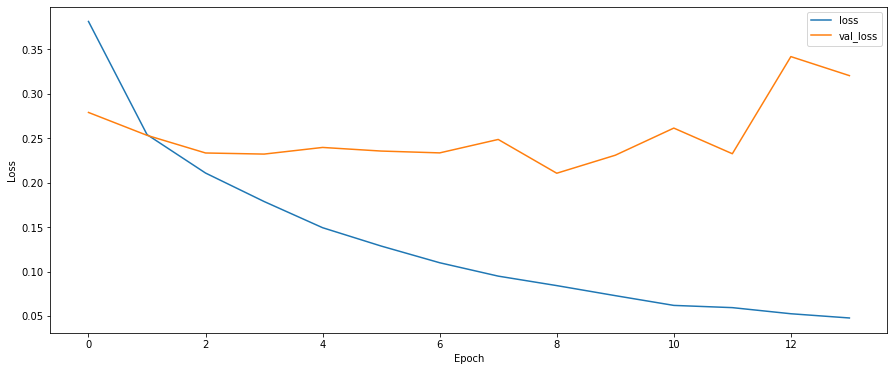

In [74]:
plt.figure(figsize=(15, 6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

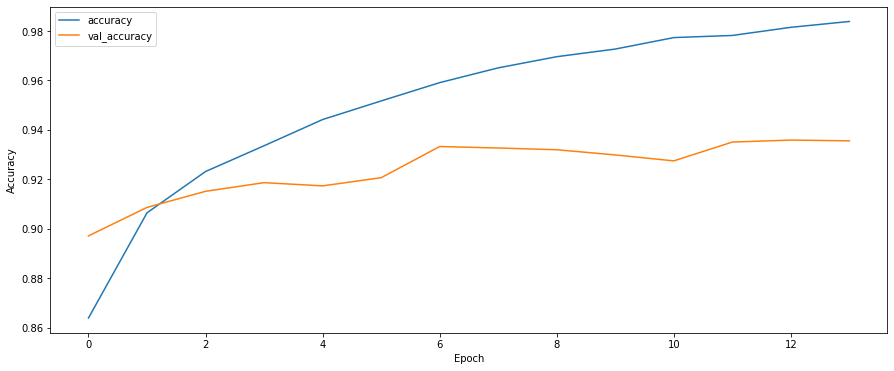

In [75]:
plt.figure(figsize=(15, 6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [69]:
preds = model.predict(x_test)
predictions= np.argmax(preds, axis=1)

In [ ]:
accuracy_score(y, np.argmax(y_train, axis=1))

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
print(confusion_matrix(y_test, predictions))

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [76]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))    # num_classes = 10

# Checking the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

In [77]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test,y_test), callbacks=[early_stop])

Epoch 1/100
1875/1875 [==============================] - 90s 47ms/step - loss: 0.4857 - accuracy: 0.8342 - val_loss: 0.3217 - val_accuracy: 0.8790
Epoch 2/100
1875/1875 [==============================] - 87s 46ms/step - loss: 0.3015 - accuracy: 0.8943 - val_loss: 0.2708 - val_accuracy: 0.9094
Epoch 3/100
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2660 - accuracy: 0.9078 - val_loss: 0.2248 - val_accuracy: 0.9177
Epoch 4/100
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2327 - accuracy: 0.9194 - val_loss: 0.2492 - val_accuracy: 0.9095
Epoch 5/100
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2084 - accuracy: 0.9274 - val_loss: 0.2147 - val_accuracy: 0.9235
Epoch 6/100
1875/1875 [==============================] - 85s 45ms/step - loss: 0.1886 - accuracy: 0.9328 - val_loss: 0.2360 - val_accuracy: 0.9204
Epoch 7/100
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1648 - accuracy: 0.9438 - val_loss: 0

In [80]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.32835081219673157
Test accuracy: 0.9320999979972839


In [81]:
preds = model.predict(x_test)
predictions= np.argmax(preds, axis=1)

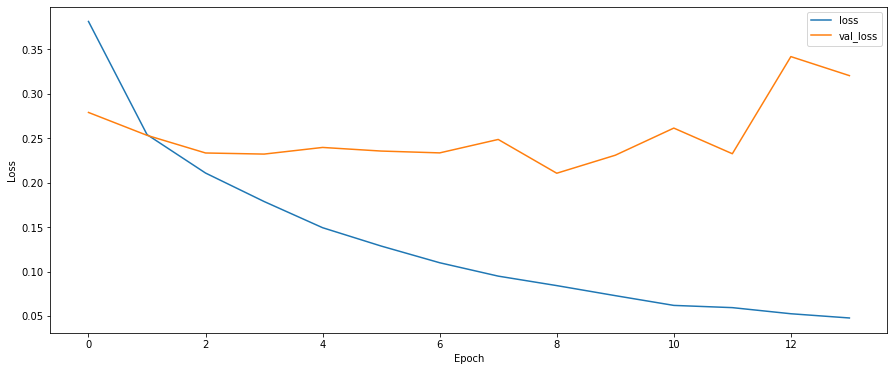

In [83]:
plt.figure(figsize=(15, 6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

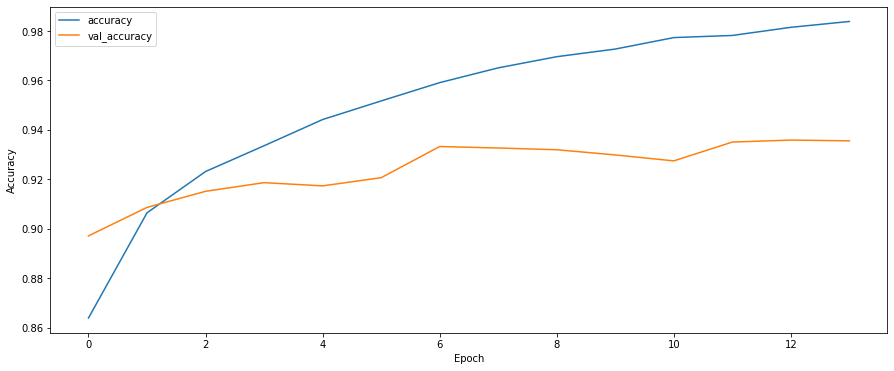

In [84]:
plt.figure(figsize=(15, 6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()